# Exploring the two scalar fields model

In this notebook, I try to reproduce some figures from https://arxiv.org/abs/2211.13653

Author: João Victor Rebouças, March 2024

In [41]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Units: assume reduced natural units: $c = 8 \pi G = \hbar = 1$

In [42]:
# Constants
c = 3e5 # km/s
hc_in_evcm = 1.23e-8 # Value of rho_cr from https://pdg.lbl.gov/2015/reviews/rpp2015-rev-astrophysical-constants.pdf
rho_cr_over_h2_in_gev4 = 1.053e-5 / (8065.544e9)**3

# Fixed parameters from Planck 2018
h = 0.6756
omega_c = 0.12/h**2
omega_b = 0.022/h**2
omega_phot = 2.47e-5/h**2
omega_massless_nu = 3*(7/8)*(4/11)**(4/3)*omega_phot
omega_r = omega_phot + omega_massless_nu

In [85]:
def H_curly(y: list[float], a: float, V0: float, rho_dm: float):
	_, phi_prime = y
	rho = omega_r * a**(-4) + omega_b * a**(-3) + rho_dm + phi_prime**2/(2*a**2) + V0
	return a * np.sqrt(rho)

def equations(y: list[float], a: float, V0: float, rho_dm_i: float, a_i: float, phi_i: float) -> list[float]:
	phi, phi_prime = y
	rho_dm = rho_dm_i*(phi/phi_i)*(a_i/a)**3
	H = H_curly(y, a, V0, rho_dm)
	dphi = phi_prime/(a*H)
	dphi_prime = -2*phi_prime/a - a*rho_dm/(phi*H)
	return np.array([dphi, dphi_prime])

def equations_loga(y: list[float], loga: float, V0: float, rho_dm_i: float, a_i: float, phi_i: float) -> list[float]:
	a = np.exp(loga)
	derivs = equations(y, a, V0, rho_dm_i, a_i, phi_i)
	return a*derivs

def integrate_cosmo(ic: list[float], a_ini: float, a_end: float, n_steps: int, V0: float, rho_dm_i: float) -> list[list[float], list[float]]:
	# Integrates first with respect to log(a)
	frac = 0.4
	a_treshold = 1e-3
	n_steps_log = int(frac*n_steps)
	a_log = np.logspace(np.log10(a_ini), np.log10(a_treshold), n_steps_log)
	loga = np.log(a_log)
	phi_i = ic[0]
	result_log = odeint(equations_loga, ic, loga, args=(V0, rho_dm_i, a_ini, phi_i))
	ic_normal_integration = result_log[-1]
	a = np.linspace(a_treshold, a_end, n_steps-n_steps_log)
	result_normal = odeint(equations, ic_normal_integration, a, args=(V0, rho_dm_i, a_ini, phi_i))
	return np.concatenate((a_log, a)), np.concatenate((result_log, result_normal))

def find_fde_0(result, V0, rho_dm):
	phi, phi_prime = result.T
	rho_phi_0 = phi_prime[-1]**2/(2) + V0
	rho_tot = omega_r + omega_b + rho_dm + rho_phi_0
	return rho_phi_0/rho_tot

def solve_system(ic, a_ini, a_end, n_steps):
	target_omega_de = 1 - omega_b - omega_c - omega_r
	V0_1 = 1.1*target_omega_de
	V0_2 = 0.9*target_omega_de
	rho_dm_i_guess = omega_c*a_ini**(-3)
	a, result_1 = integrate_cosmo(ic, a_ini, a_end, n_steps, V0_1, rho_dm_i_guess)
	a, result_2 = integrate_cosmo(ic, a_ini, a_end, n_steps, V0_2, rho_dm_i_guess)
	rho_dm_i = rho_dm_i_guess*(ic[0]/result_1.T[0][-1])
	rho_dm_0_1 = rho_dm_i*(result_1.T[0][-1]/ic[0])*(a_ini)**3
	rho_dm_0_2 = rho_dm_i*(result_2.T[0][-1]/ic[0])*(a_ini)**3
	fde_1 = find_fde_0(result_1, V0_1, rho_dm_0_1)
	fde_2 = find_fde_0(result_2, V0_2, rho_dm_0_2)
	print(f"Target omega_de: {target_omega_de}")
	print(f"V0 = {V0_1} => omega_de = {fde_1}; omega_c = {rho_dm_0_1}")
	print(f"V0 = {V0_2} => omega_de = {fde_2}; omega_c = {rho_dm_0_2}")

	encapsulating = (fde_1 - target_omega_de)*(fde_2 - target_omega_de) < 0
	if not encapsulating:
		print("ERROR: initial guesses for V0 did not encapsulate the target omega_de")
		print(f"Target omega_de: {target_omega_de}")
		print(f"V0 = {V0_1} => omega_de = {fde_1}")
		print(f"V0 = {V0_2} => omega_de = {fde_2}")
		return None
	
	iters = 0
	max_iters = 20
	while (iters < max_iters):
		a_line = (fde_2 - fde_1)/(V0_2 - V0_1)
		b_line = fde_2 - a_line*V0_2
		V0_try = (target_omega_de - b_line)/a_line
		a, result_try = integrate_cosmo(ic, a_ini, a_end, n_steps, V0_try, rho_dm_i)
		rho_dm_0_try = rho_dm_i*(result_try.T[0][-1]/ic[0])*(a_ini)**3
		fde_try = find_fde_0(result_try, V0_try, rho_dm_0_try)
		error = (fde_try - target_omega_de)/target_omega_de
		error_omega_c = (rho_dm_0_try - omega_c)/omega_c
		print(f"V0 = {V0_2} => omega_de = {fde_2} (error = {error}); omega_c = {rho_dm_0_try} (error = {error_omega_c})")
		rho_dm_i = rho_dm_i_guess*(ic[0]/result_try.T[0][-1])
		if error < 1e-4: break
		if (fde_try > target_omega_de):
			V0_2 = V0_try
			fde_2 = fde_try
		else:
			V0_1 = V0_try
			fde_1 = fde_try
		iters += 1
	if iters == max_iters:
		print("ERROR: reached max iterations in shooting")
		return None
	return a, result_try, V0_try, rho_dm_i

In [86]:
# Getting results
a_ini = 1e-14
n_steps = 10_000

phi_i = 8
ic = [phi_i, 0]
a, result_8, V0_8, rho_dm_i_8 = solve_system(ic, a_ini, 1, n_steps)

phi_i = 10
ic = [phi_i, 0]
a, result_10, V0_10, rho_dm_i_10 = solve_system(ic, a_ini, 1, n_steps)

phi_i = 15
ic = [phi_i, 0]
a, result_15, V0_15, rho_dm_i_15 = solve_system(ic, a_ini, 1, n_steps)

phi_i = 20
ic = [phi_i, 0]
a, result_20, V0_20, rho_dm_i_20 = solve_system(ic, a_ini, 1, n_steps)

Target omega_de: 0.6888025313108112
V0 = 0.7576827844418923 => omega_de = 0.7089909683695352; omega_c = 0.26290688784497335
V0 = 0.61992227817973 => omega_de = 0.6660403132990406; omega_c = 0.26280837993920714
V0 = 0.61992227817973 => omega_de = 0.6660403132990406 (error = 0.0025451129932922527); omega_c = 0.2624690957449923 (error = -0.0016651982896665914)
V0 = 0.692930121059066 => omega_de = 0.6905556115830629 (error = -0.0006497301249045336); omega_c = 0.2628931309106935 (error = -5.2326260420792176e-05)
Target omega_de: 0.6888025313108112
V0 = 0.7576827844418923 => omega_de = 0.7089415264336687; omega_c = 0.2629068878449733
V0 = 0.61992227817973 => omega_de = 0.6659432897096964; omega_c = 0.26284705579180884
V0 = 0.61992227817973 => omega_de = 0.6659432897096964 (error = 0.0022900690582893014); omega_c = 0.26272942019399703 (error = -0.0006750209263475283)
V0 = 0.6931601813047893 => omega_de = 0.6903799366750374 (error = -0.0003494292715782834); omega_c = 0.262902199974394 (error =

In [87]:
# Calculating densities
rho_r_a = omega_r * a**(-4)
rho_b_a = omega_b * a**(-3)
rho_dm_a_lcdm = omega_c * a**(-3)
rho_de_a_lcdm = (1-omega_c-omega_b-omega_r)*np.ones((n_steps))

phi_a_8, phi_prime_a_8 = result_8.T
phi_a_10, phi_prime_a_10 = result_10.T
phi_a_15, phi_prime_a_15 = result_15.T
phi_a_20, phi_prime_a_20 = result_20.T

rho_de_a_8 = phi_prime_a_8**2/(2*a**2) + V0_8
rho_de_a_10 = phi_prime_a_10**2/(2*a**2) + V0_10
rho_de_a_15 = phi_prime_a_15**2/(2*a**2) + V0_15
rho_de_a_20 = phi_prime_a_20**2/(2*a**2) + V0_20

rho_dm_a_8 = rho_dm_i_8*(phi_a_8/8)*(a_ini/a)**3
rho_dm_a_10 = rho_dm_i_10*(phi_a_10/10)*(a_ini/a)**3
rho_dm_a_15 = rho_dm_i_15*(phi_a_15/15)*(a_ini/a)**3
rho_dm_a_20 = rho_dm_i_20*(phi_a_20/20)*(a_ini/a)**3

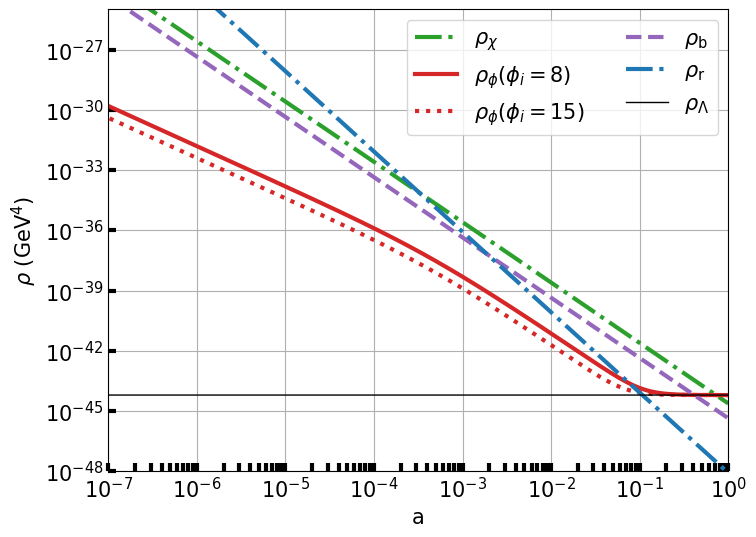

In [88]:
rho_cr_in_gev4 = rho_cr_over_h2_in_gev4 * h**2
plt.figure(figsize=(8,6))
plt.loglog(a, rho_cr_in_gev4*rho_dm_a_8, color='tab:green', ls='-.', lw=3, label=r"$\rho_\chi$")
plt.loglog(a, rho_cr_in_gev4*rho_de_a_8, color='tab:red', ls='-', lw=3, label=r"$\rho_\phi (\phi_i = 8)$")
plt.loglog(a, rho_cr_in_gev4*rho_de_a_15, color='tab:red', ls=':', lw=3, label=r"$\rho_\phi (\phi_i = 15)$")
plt.loglog(a, rho_cr_in_gev4*rho_b_a, color='tab:purple', ls='--', lw=3, label=r"$\rho_\mathrm{b}$")
plt.loglog(a, rho_cr_in_gev4*rho_r_a, color='tab:blue', ls='-.', lw=3, label=r"$\rho_\mathrm{r}$")
plt.loglog(a, rho_cr_in_gev4*rho_de_a_lcdm, color='black', ls='-', lw=1, label=r"$\rho_\Lambda$")

plt.xlim([1e-7, 1])
plt.ylim([1e-48, 1e-25])

plt.xlabel("a", fontsize=15)
plt.ylabel(r"$\rho$ ($\mathrm{GeV}^4$)", fontsize=15)

plt.tick_params(axis="both", which="both", direction="in", length=6, width=3)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.grid()
plt.legend(fontsize=15, ncol=2)

plt.savefig("fig2.pdf")

In [89]:
rho_tot_a_8 = rho_r_a + rho_b_a + rho_dm_a_8 + rho_de_a_8
rho_tot_a_10 = rho_r_a + rho_b_a + rho_dm_a_10 + rho_de_a_10
rho_tot_a_lcdm = rho_r_a + rho_b_a + rho_dm_a_lcdm + rho_de_a_lcdm

f_r_a_8 = rho_r_a/rho_tot_a_8
f_r_a_10 = rho_r_a/rho_tot_a_10
f_r_a_lcdm = rho_r_a/rho_tot_a_lcdm
f_b_a_8 = rho_b_a/rho_tot_a_8
f_b_a_10 = rho_b_a/rho_tot_a_10
f_b_a_lcdm = rho_b_a/rho_tot_a_lcdm
f_dm_a_8 = rho_dm_a_8/rho_tot_a_8
f_dm_a_10 = rho_dm_a_10/rho_tot_a_10
f_dm_a_lcdm = rho_dm_a_lcdm/rho_tot_a_lcdm
f_de_a_8 = rho_de_a_8/rho_tot_a_8
f_de_a_10 = rho_de_a_10/rho_tot_a_10
f_de_a_lcdm = rho_de_a_lcdm/rho_tot_a_lcdm

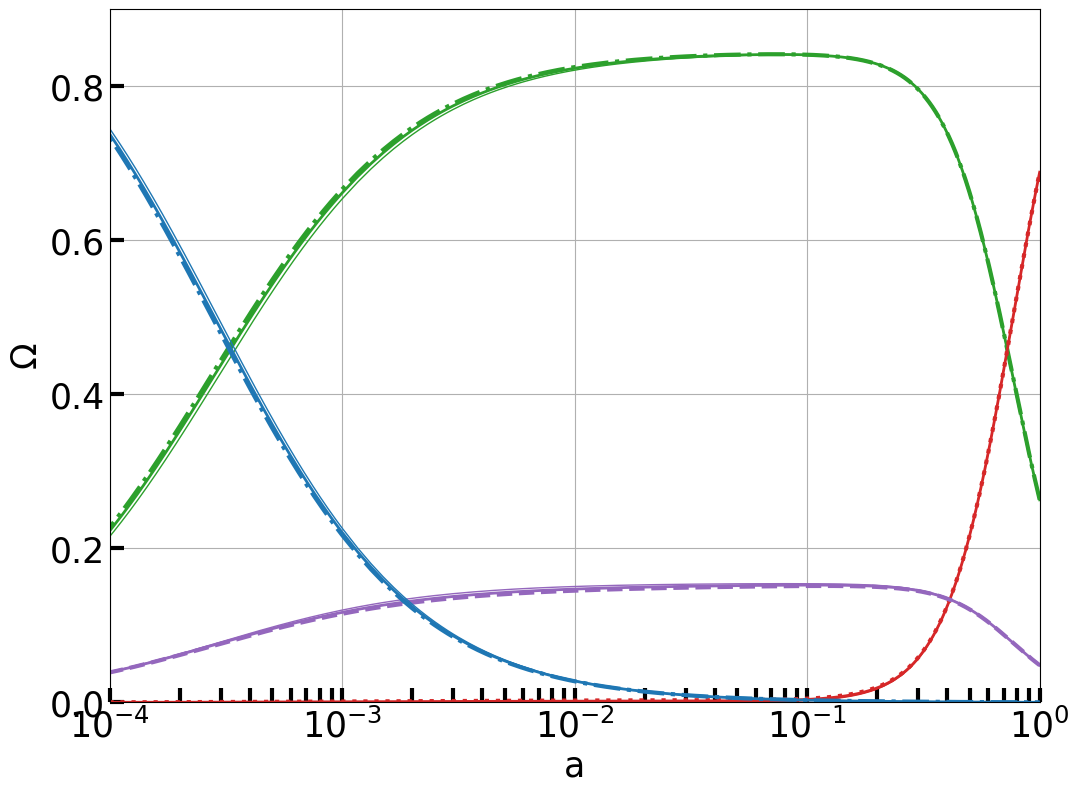

In [90]:
factor=3
plt.figure(figsize=(4*factor,3*factor))
plt.semilogx(a, f_dm_a_8, color='tab:green', ls='-.', lw=3)
plt.semilogx(a, f_dm_a_10, color='tab:green', ls='-', lw=2)
plt.semilogx(a, f_dm_a_lcdm, color='tab:green', ls='-', lw=1)
plt.semilogx(a, f_de_a_8, color='tab:red', ls=':', lw=3)
plt.semilogx(a, f_de_a_10, color='tab:red', ls='-', lw=2)
plt.semilogx(a, f_de_a_lcdm, color='tab:red', ls='-', lw=1)
plt.semilogx(a, f_b_a_8, color='tab:purple', ls='--', lw=3)
plt.semilogx(a, f_b_a_10, color='tab:purple', ls='-', lw=2)
plt.semilogx(a, f_b_a_lcdm, color='tab:purple', ls='-', lw=1)
plt.semilogx(a, f_r_a_8, color='tab:blue', ls='-.', lw=3)
plt.semilogx(a, f_r_a_10, color='tab:blue', ls='-', lw=2)
plt.semilogx(a, f_r_a_lcdm, color='tab:blue', ls='-', lw=1)
plt.xlim([1e-4, 1])
plt.ylim([0, 0.9])

plt.xlabel("a", fontsize=25)
plt.ylabel(r"$\Omega$", fontsize=25)
plt.tick_params(axis="both", which="both", direction="in", length=10, width=3)

plt.yticks([0.2*i for i in range(5)], fontsize=25)
plt.xticks(fontsize=25)

plt.grid()

plt.savefig("fig1.pdf")

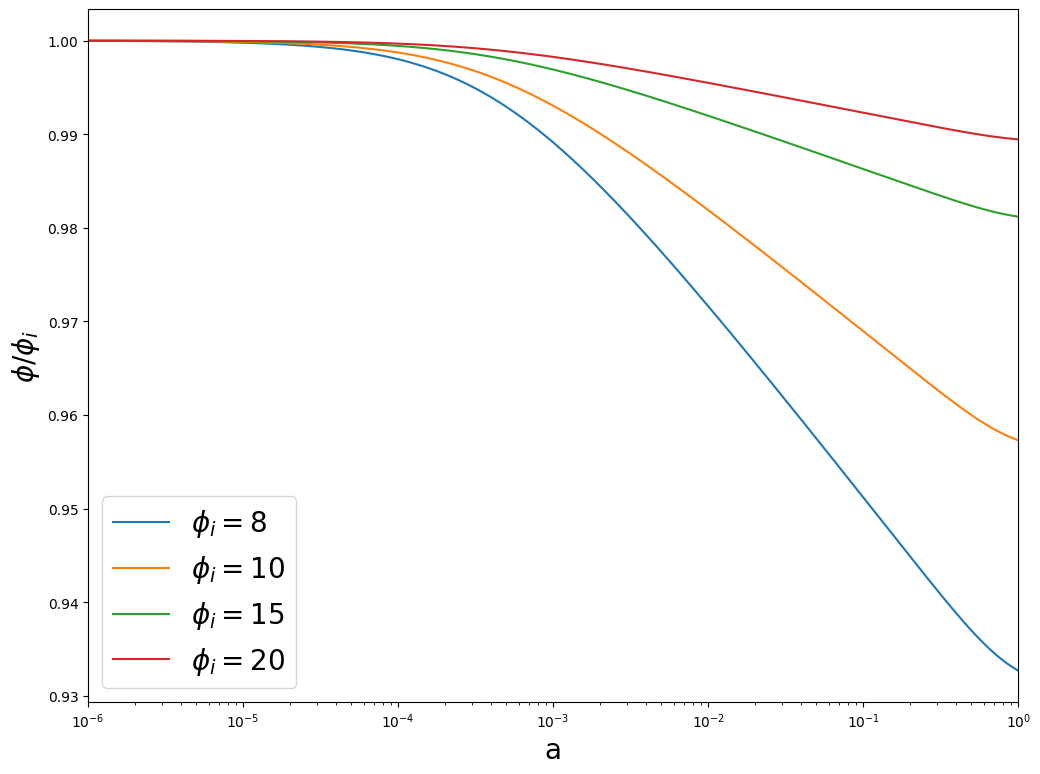

In [49]:
factor=3
plt.figure(figsize=(4*factor,3*factor))

plt.semilogx(a, phi_a_8/8, label=r'$\phi_i = 8$')
plt.semilogx(a, phi_a_10/10, label=r'$\phi_i = 10$')
plt.semilogx(a, phi_a_15/15, label=r'$\phi_i = 15$')
plt.semilogx(a, phi_a_20/20, label=r'$\phi_i = 20$')

plt.xlabel("a", fontsize=20)
plt.ylabel(r"$\phi/\phi_i$", fontsize=20)

plt.xlim([1e-6, 1])

plt.legend(fontsize=20)

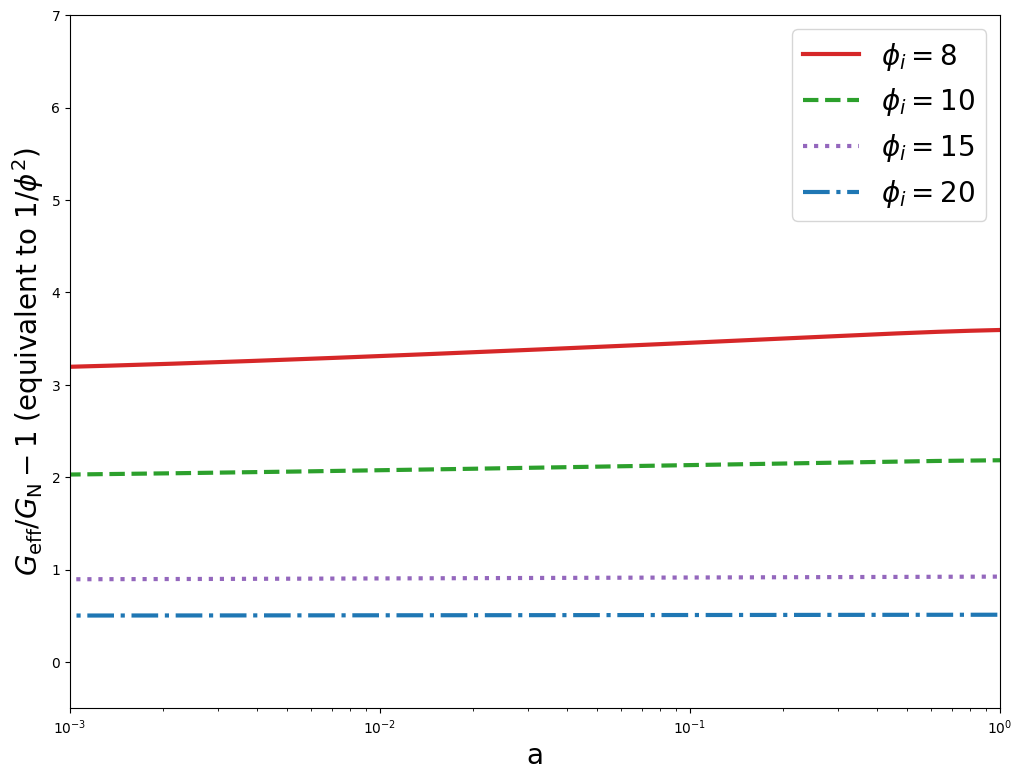

In [50]:
factor=3
plt.figure(figsize=(4*factor,3*factor))

plt.semilogx(a, 100*2/(phi_a_8)**2, color="tab:red", ls="-", lw=3, label=r'$\phi_i = 8$')
plt.semilogx(a, 100*2/(phi_a_10)**2, color="tab:green", ls="--", lw=3, label=r'$\phi_i = 10$')
plt.semilogx(a, 100*2/(phi_a_15)**2, color="tab:purple", ls=":", lw=3, label=r'$\phi_i = 15$')
plt.semilogx(a, 100*2/(phi_a_20)**2, color="tab:blue", ls="-.", lw=3, label=r'$\phi_i = 20$')

plt.xlabel("a", fontsize=20)
plt.ylabel(r"$G_\mathrm{eff}/G_\mathrm{N} - 1$ (equivalent to $1/\phi^2$)", fontsize=20)

plt.xlim([1e-3, 1])
plt.ylim([-0.5, 7])

plt.legend(fontsize=20)


In [24]:
(f_dm_a_8[-1] - omega_c)/omega_c

-0.011524728145791169

In [25]:
def rho_total(a):
    return omega_r*a**(-4) + (omega_b + omega_c)*a**(-3) + (1 - omega_r - omega_b - omega_c)

def cdm_frac(a):
    return omega_c*a**(-3)/rho_total(a)

def phot_frac(a):
    return omega_r*a**(-4)/rho_total(a)

In [40]:
cdm_frac(1e-4)

0.21532909047594775

In [38]:
phot_frac(1e-4)

0.7451939096028979

In [39]:
omega_c

0.2629068878449733